Tasks:
Investigate the missing data in this dataset. Specifically, for each of the following variables that have missing data, decide if any imputation is possible. Give your reasoning and code if you decide to impute missing values.
Columns for investigation: CARRIER, CARRIER_NAME, MANUFACTURE_YEAR, NUMBER_OF_SEATS, CAPACITY_IN_POUNDS, and AIRLINE_ID.
For example, watch out for "North American Airlines" aircrafts. Are the CARRIER/UNIQUE_CARRIER column really missing?
Inspect the columns MANUFACTURER, MODEL, AIRCRAFT_STATUS, and OPERATING_STATUS. Decide, for each column, if transformation or standardization of data are required. Give your reasoning and code if you decide to transform the data.
Hints:
For very messy data like manufacturer/model names, give your best attempt. It is okay to not catch them all.
Use value_counts() to identify "big wins".
Break down into multiple steps, instead of having one line of code to do them all.
Remove data rows that still have missing values. Report the amount of remaining data you obtained.
Transformation and derivative variables
For the columns NUMBER_OF_SEATS and CAPACITY_IN_POUNDS, check the skewness in the variable and plot a histogram for each variable.
The Box-Cox transformation (scipy.stats.boxcox) is one possible way to transform variables into a "more-normal-like" variable. Apply the Box-Cox transformation for these two columns and save them as new columns, i.e. XXXXXXXXX_BOXCOX.
Plot a histogram for each transformed variable.
Describe what you observe before and after transformation.
Feature engineering
Create a new column SIZE by the quartiles of NUMBER_OF_SEATS
below 25% percentile: SMALL
25% - 50% percentile: MEDIUM
50% - 75% percentile: LARGE
above 75% percentile: XLARGE
For each size group, provide and plot the proportions of aircrafts that are operating versus not (OPERATING_STATUS).
For each size group, provide and plot the proportions of aircrafts belonging to each aircraft status group (AIRCRAFT_STATUS).
Provide a written summary of your findings.


In [121]:
import miceforest as mf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import missingno as msno
import matplotlib.pyplot as plt

In [122]:
import pandas as pd
inventory = pd.read_csv('dataset/T_F41SCHEDULE_B43.zip')
inventory.info()

C:\Users\vDxbs\AppData\Local\Temp\ipykernel_18704\1321453169.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv('dataset/T_F41SCHEDULE_B43.zip')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132264 non-null  object 
 2   CARRIER_NAME         132208 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

1) Investigate the missing data in this dataset. Specifically, for each of the following variables that have missing data, decide if any imputation is possible. Give your reasoning and code if you decide to impute missing values.

CARRIER and CARRIER_NAME can partially be imputed by relating them to one another. The only 'missing' carrier is NA for North American Airlines so we can manually impute that. For carrier names, the ones that are missing have carrier columns of L4 and OH. From the dataset OH has been used for two carrier names so we cannot assume either. On the other hand, L4 is only used for one carrier name so we can insert Lynx Aviation for the missing L4 carrier names. Similarly we can assume the AIRLINE_ID for the missing L4 rows is 21217.

I do not believe we can impute the few missing MANUFACTURE_YEAR entries because that can vary a lot even with the data we have in the other columns. For CAPACITY_IN_POUNDS and NUMBER_OF_SEATS, we should be able to use predictive imputation based on the model of the plane which determines the seat and weight capacities. 

In [123]:
imputed_inv = inventory.copy()
# manual imputations
imputed_inv.loc[inventory['CARRIER'].isna(), 'CARRIER'] = 'NA'
imputed_inv.loc[imputed_inv['CARRIER_NAME'].isna() & (imputed_inv['CARRIER'] == 'L4'), 'CARRIER_NAME'] = 'Lynx Aviation d/b/a Frontier Airlines'
imputed_inv.loc[imputed_inv['AIRLINE_ID'].isna() & (imputed_inv['CARRIER'] == 'L4'), 'AIRLINE_ID'] = 21217


# create temporary copy with encoded model column for predictions
temp = imputed_inv.copy()
le = LabelEncoder()
temp['MODEL_ENC'] = le.fit_transform(temp['MODEL'].astype(str))

fs = ['MODEL_ENC','CAPACITY_IN_POUNDS', 'NUMBER_OF_SEATS']
imputer = KNNImputer(n_neighbors=5)
imputedValues = imputer.fit_transform(temp[fs])

# insert values
imputed_inv[['CAPACITY_IN_POUNDS', 'NUMBER_OF_SEATS']] = imputedValues[:,1:]

<Axes: >

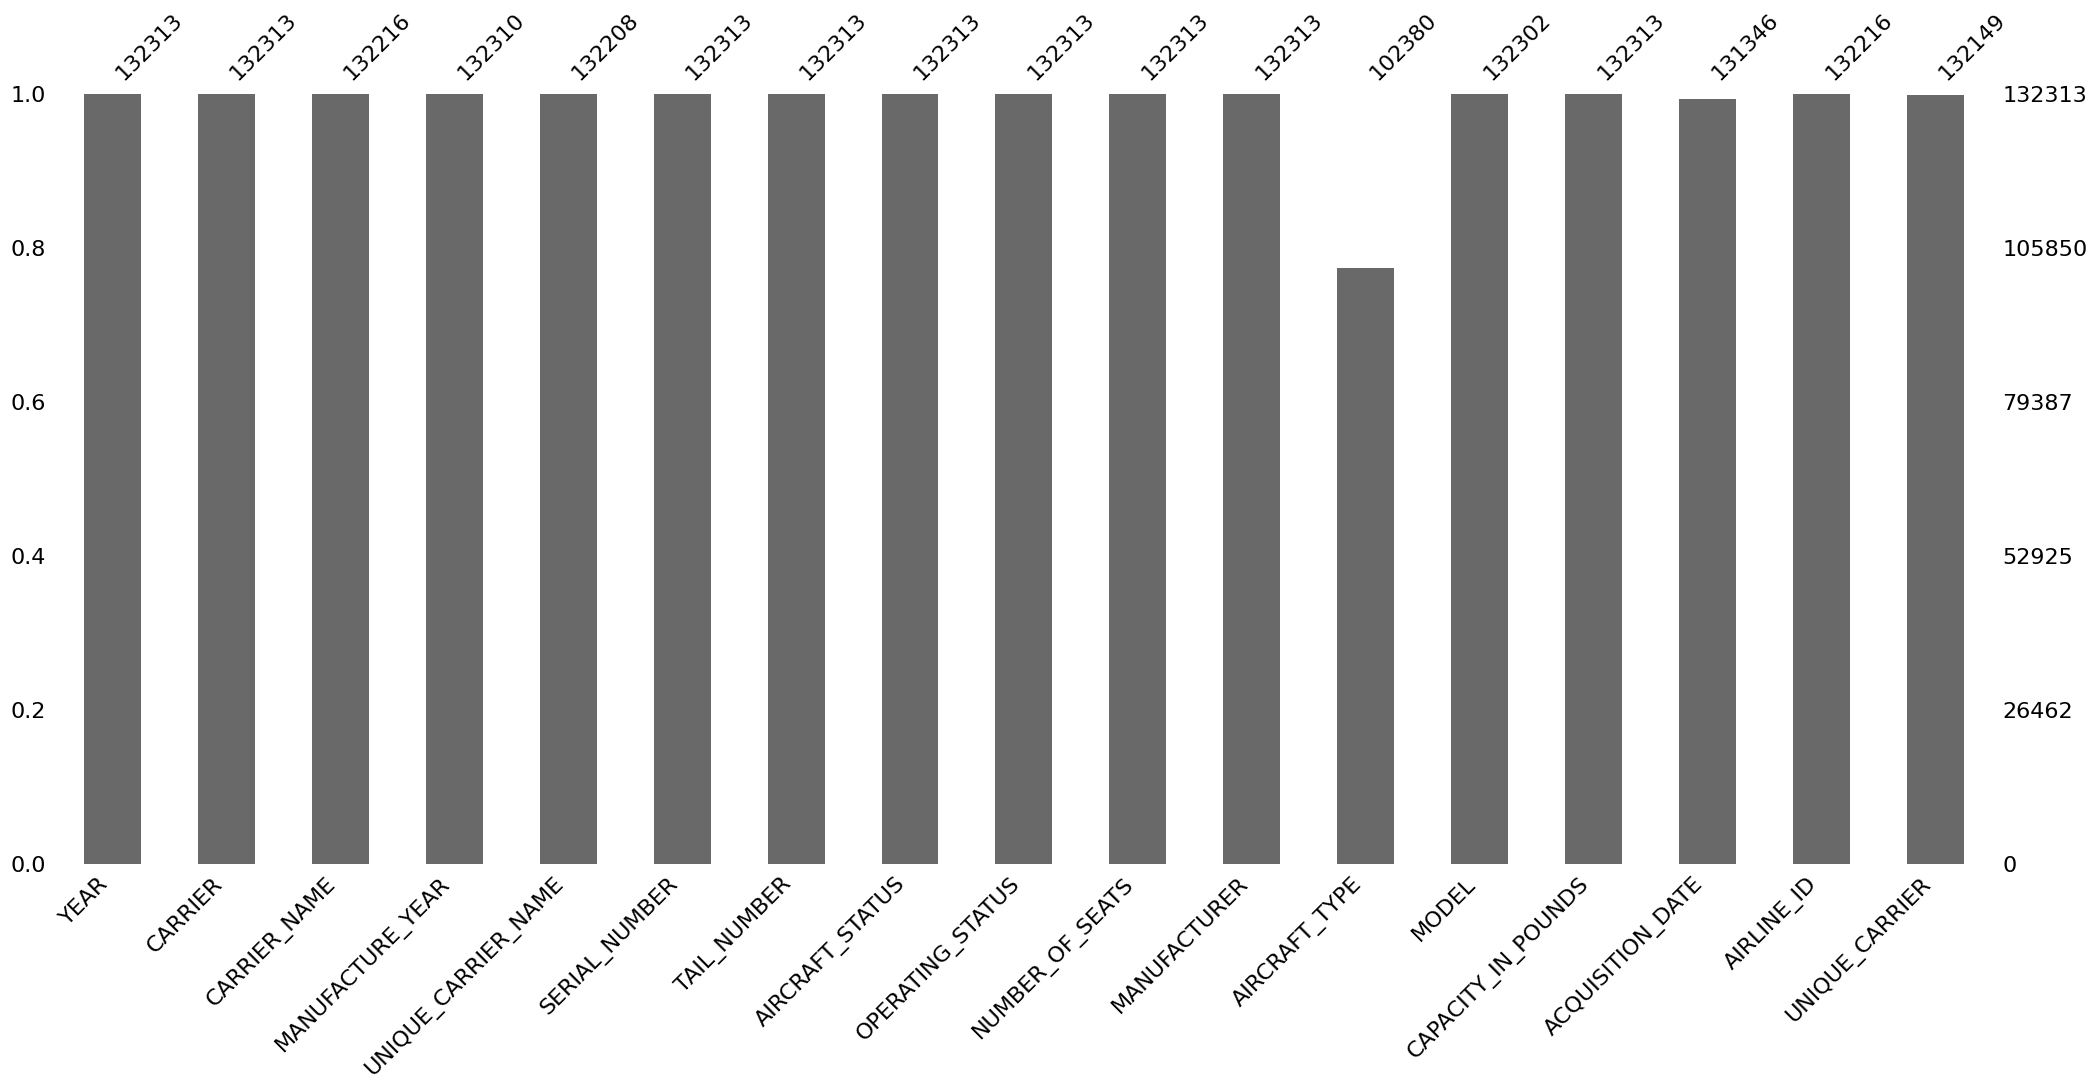

In [124]:
import missingno as msno
msno.bar(imputed_inv)
### of the columns to investigate, number of seats and capacity make sense to be imputed since I believe they can be estimated using the model since the models of a plane typically have the same seats and capacity ###

2) Inspect the columns MANUFACTURER, MODEL, AIRCRAFT_STATUS, and OPERATING_STATUS. Decide, for each column, if transformation or standardization of data are required. Give your reasoning and code if you decide to transform the data.


For manufacturing, I will transform the inputs to be more consistent since some manufacturers are entered under differnet names (ex. BOEING vs boeing vs THEBOEINGCOMPANY)
For aircraft/operating status and model, I will simply remove inconsistent punctuation and make them uppercase

In [125]:
# Manufacturing
mf_map = {
    'THEBOEINGCO' : 'BOEING',
    'Boeing' : 'BOEING',
    'BoeingCo' : 'BOEING',
    'BOEINGCOMPANY' : 'BOEING',
    'THEBOEINGCOMPANY' : 'BOEING',
    'TheBoeingCompany' : 'BOEING',

    'AirbusIndustries' : 'AIRBUS',
    'AirbusIndustrie' : 'AIRBUS',
    'Airbus' : 'AIRBUS',

    'Embraer' : 'EMBRAER',

    'MCDONNELL-DOUGLAS' : 'MCDONNELLDOUGLAS',
    'McDonnellDouglas' : 'MCDONNELLDOUGLAS',
}

imputed_inv['MANUFACTURER'] = imputed_inv['MANUFACTURER'].replace(mf_map)

In [126]:
imputed_inv['MODEL'] = imputed_inv['MODEL'].str.upper().str.strip()
imputed_inv['AIRCRAFT_STATUS'] = imputed_inv['AIRCRAFT_STATUS'].str.upper().str.strip()

op_map = {
    '' : 'N'
}
imputed_inv['OPERATING_STATUS'] = imputed_inv['OPERATING_STATUS'].replace(op_map)
imputed_inv['OPERATING_STATUS'] = imputed_inv['OPERATING_STATUS'].str.upper().str.strip()


In [127]:
imputed_inv['OPERATING_STATUS'].value_counts().head(10)

OPERATING_STATUS
Y    126648
N      5664
          1
Name: count, dtype: int64

We finish with 101275 rows of remaining data

In [128]:
imputed_inv = imputed_inv.dropna()
imputed_inv

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
29239,2010,0JQ,Vision Airlines,1982.0,Vision Airlines,21866,N769VA,B,Y,92.0,BOEING,6251.0,B767-2-PSGR,68242.0,9/1/2007 12:00:00 AM,21236.0,0JQ
29240,2010,0JQ,Vision Airlines,1982.0,Vision Airlines,21869,N768VA,B,Y,86.0,BOEING,6251.0,B767-2-PSGR,69822.0,9/1/2007 12:00:00 AM,21236.0,0JQ
29241,2010,0JQ,Vision Airlines,1982.0,Vision Airlines,21870,N767VA,B,Y,86.0,BOEING,6251.0,B767-2-PSGR,66443.0,7/1/2007 12:00:00 AM,21236.0,0JQ
29242,2010,0JQ,Vision Airlines,1985.0,Vision Airlines,23366,N732VA,B,Y,136.0,BOEING,6191.0,B737-300-PSGR,32282.0,7/1/2008 12:00:00 AM,21236.0,0JQ
29243,2010,0JQ,Vision Airlines,1985.0,Vision Airlines,8044,N407VA,B,N,19.0,Dornier,4481.0,DO-228-PSGR,0.0,12/1/2003 12:00:00 AM,21236.0,0JQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132308,2023,ZW,Air Wisconsin Airlines Corp,2004.0,Air Wisconsin Airlines Corp,7899,N466AW,O,Y,50.0,Bombardier,6291,CL-600-2B19,12972.0,1/21/2004 12:00:00 AM,20046.0,ZW
132309,2023,ZW,Air Wisconsin Airlines Corp,2004.0,Air Wisconsin Airlines Corp,7900,N467AW,O,Y,50.0,Bombardier,6291,CL-600-2B19,12972.0,1/23/2004 12:00:00 AM,20046.0,ZW
132310,2023,ZW,Air Wisconsin Airlines Corp,2004.0,Air Wisconsin Airlines Corp,7916,N468AW,O,Y,50.0,Bombardier,6291,CL-600-2B19,12972.0,3/25/2004 12:00:00 AM,20046.0,ZW
132311,2023,ZW,Air Wisconsin Airlines Corp,2004.0,Air Wisconsin Airlines Corp,7917,N469AW,O,Y,50.0,Bombardier,6291,CL-600-2B19,12972.0,3/18/2004 12:00:00 AM,20046.0,ZW


4) For the columns NUMBER_OF_SEATS and CAPACITY_IN_POUNDS, check the skewness in the variable and plot a histogram for each variable.
The Box-Cox transformation (scipy.stats.boxcox) is one possible way to transform variables into a "more-normal-like" variable. Apply the Box-Cox transformation for these two columns and save them as new columns, i.e. XXXXXXXXX_BOXCOX.

After the treansformation, the values are much closer to a normal distribution but number of seats has a large amount of 0 entries which results in a spike at 0 but the nonzero entries are properly transformed to be more normal. 

-1.7868951928328567
-6.455851774722862


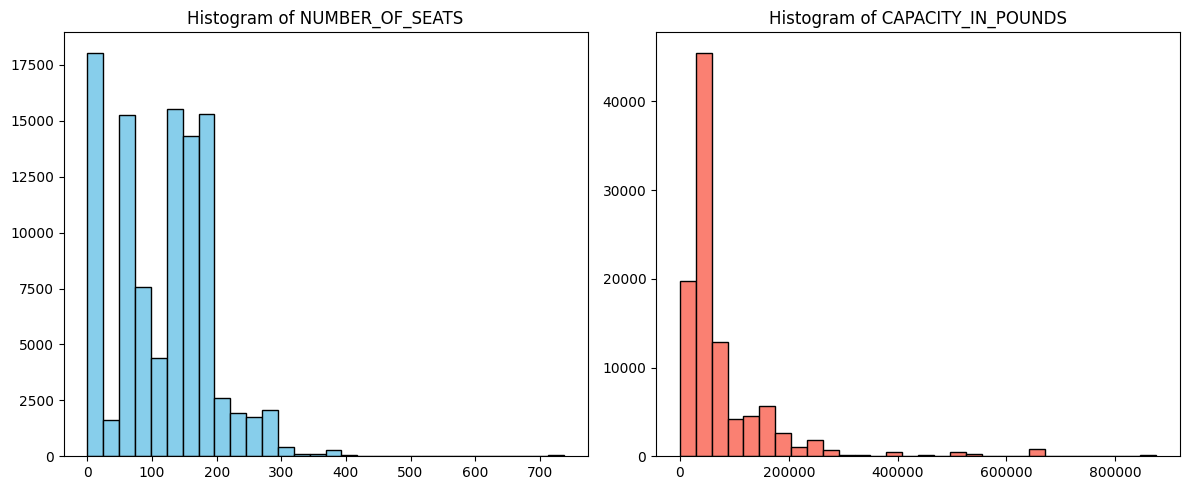

In [129]:
from scipy.stats import boxcox



seats = imputed_inv['NUMBER_OF_SEATS'] > 0
caps = imputed_inv['CAPACITY_IN_POUNDS'] > 0
skew_seats = seats.skew()
skew_cap = caps.skew()
print(skew_seats)
print(skew_cap)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(imputed_inv['NUMBER_OF_SEATS'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of NUMBER_OF_SEATS')

plt.subplot(1, 2, 2)
plt.hist(imputed_inv['CAPACITY_IN_POUNDS'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of CAPACITY_IN_POUNDS')

plt.tight_layout()
plt.show()



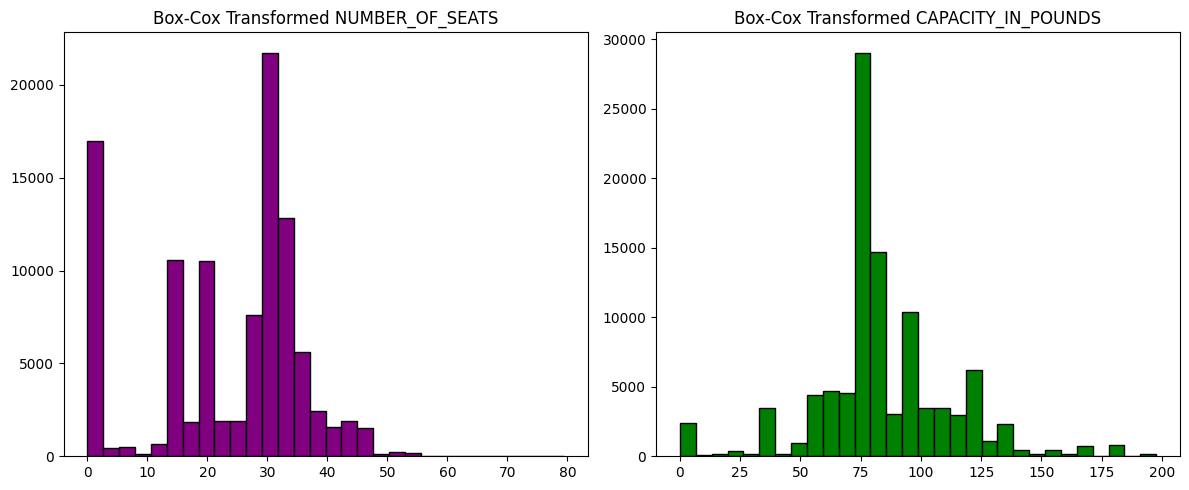

In [130]:
temp = imputed_inv.copy()
seat_data = temp['NUMBER_OF_SEATS']
capacity_data = temp['CAPACITY_IN_POUNDS']

# Ensure all values > 0
if (seat_data <= 0).any():
    seat_data += 1 - seat_data.min()

if (capacity_data <= 0).any():
    capacity_data += 1 - capacity_data.min()

# Apply Box-Cox
imputed_inv['NUMBER_OF_SEATS_BOXCOX'], _ = boxcox(seat_data)
imputed_inv['CAPACITY_IN_POUNDS_BOXCOX'], _ = boxcox(capacity_data)


#graphing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(imputed_inv['NUMBER_OF_SEATS_BOXCOX'], bins=30, color='purple', edgecolor='black')
plt.title('Box-Cox Transformed NUMBER_OF_SEATS')

plt.subplot(1, 2, 2)
plt.hist(imputed_inv['CAPACITY_IN_POUNDS_BOXCOX'], bins=30, color='green', edgecolor='black')
plt.title('Box-Cox Transformed CAPACITY_IN_POUNDS')

plt.tight_layout()
plt.show()


5) Create a new column SIZE by the quartiles of NUMBER_OF_SEATS
below 25% percentile: SMALL
25% - 50% percentile: MEDIUM
50% - 75% percentile: LARGE
above 75% percentile: XLARGE
For each size group, provide and plot the proportions of aircrafts that are operating versus not (OPERATING_STATUS).
For each size group, provide and plot the proportions of aircrafts belonging to each aircraft status group (AIRCRAFT_STATUS).
Provide a written summary of your findings.

In [ ]:
# get quartiles
q1 = imputed_inv['NUMBER_OF_SEATS'].quantile(0.25)
q2 = imputed_inv['NUMBER_OF_SEATS'].quantile(0.50)  
q3 = imputed_inv['NUMBER_OF_SEATS'].quantile(0.75)


# fill 'size' based on num seats
imputed_inv.loc[imputed_inv['NUMBER_OF_SEATS'] < q1, 'SIZE'] = 'SMALL'

imputed_inv.loc[(imputed_inv['NUMBER_OF_SEATS'] > q1) & (imputed_inv['NUMBER_OF_SEATS'] < q2), 'SIZE'] = 'MEDIUM'

imputed_inv.loc[(imputed_inv['NUMBER_OF_SEATS'] > q2) & (imputed_inv['NUMBER_OF_SEATS'] < q3), 'SIZE'] = 'LARGE'

imputed_inv.loc[imputed_inv['NUMBER_OF_SEATS'] > q3, 'SIZE'] = 'XLARGE'

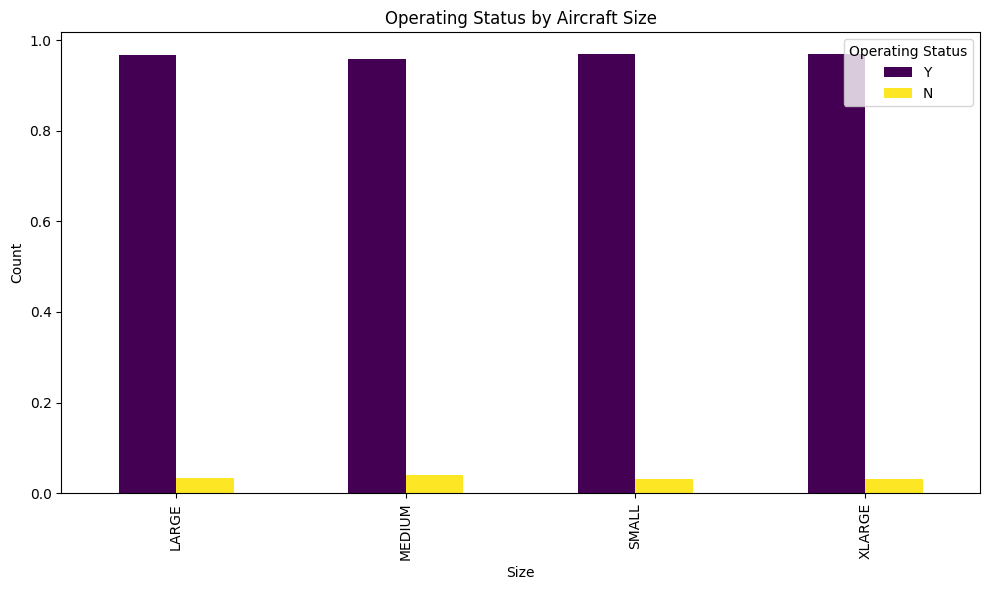

In [137]:
# graphing

groupedData = imputed_inv.groupby('SIZE')['OPERATING_STATUS'].value_counts(normalize=True).unstack().fillna(0)
groupedData.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='viridis')
plt.title('Operating Status by Aircraft Size')
plt.xlabel('Size')
plt.ylabel('Count')
plt.legend(title='Operating Status')
plt.tight_layout()
plt.show()

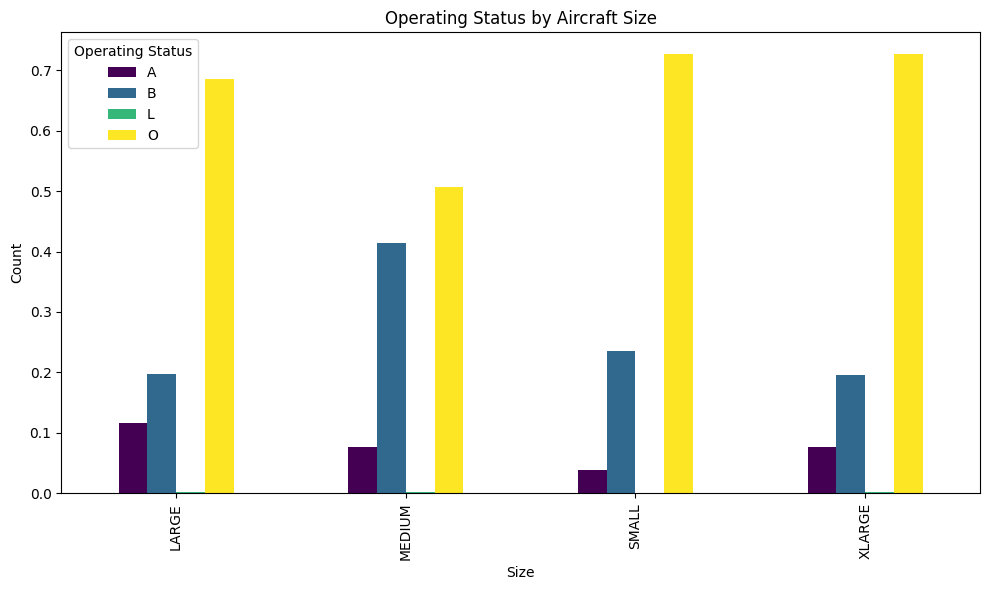

In [138]:
# graphing

groupedData = imputed_inv.groupby('SIZE')['AIRCRAFT_STATUS'].value_counts(normalize=True).unstack().fillna(0)
groupedData.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='viridis')
plt.title('Operating Status by Aircraft Size')
plt.xlabel('Size')
plt.ylabel('Count')
plt.legend(title='Operating Status')
plt.tight_layout()
plt.show()